In [ ]:
import pandas as pd
import os
import PIL
import numpy as np
from PIL import ImageEnhance, ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [ ]:
traindir = "../til2020/newlabels/trainv2"

In [ ]:
trainimgs = [i for i in os.listdir(traindir) if i.endswith("jpg")]
traintxts = [i for i in os.listdir(traindir) if i.endswith("txt")]

valtxts = [i for i in os.listdir("../til2020/newlabels/valv2") if i.endswith("txt")]

In [ ]:
trainimgs = sorted([int(x.split('.')[0]) for x in trainimgs])
trainimgs = [str(x) + '.jpg' for x in trainimgs]

In [ ]:
trainimgs[634]

'1755.jpg'

In [ ]:
traintxts = sorted([int(x.split('.')[0]) for x in traintxts])
traintxts = [str(x) + '.txt' for x in traintxts]

In [ ]:
traintxts.index("10959.txt")

5079

In [ ]:
trainimgs.index("10959.jpg")

5079

In [ ]:
traintxts.pop(5079)
trainimgs.pop(5079)

'10959.jpg'

<h1>Check if blank txt files are present<h1>

In [ ]:
errors = []
for i in traintxts:
    with open(os.path.join(traindir, i), "r") as f:
        first = f.read(1)
        if not first:
            errors.append(i)
errors

['10959.txt']

In [ ]:
errors = []
for i in valtxts:
    with open(os.path.join("../til2020/newlabels/valv2", i), "r") as f:
        first = f.read(1)
        if not first:
            errors.append(i)
errors

[]

In [ ]:
traintxts[0]

'5.txt'

In [ ]:
len(trainimgs) == len(traintxts)

True

In [ ]:
set([i[:-4] for i in trainimgs]) == set([i[:-4] for i in traintxts])

True

In [ ]:
categories = ["tops", "trousers", "outerwear", "dresses", "skirts"]
categories = {k: v for k,v in enumerate(categories)}

<h1>Functions to be used<h1>

In [ ]:
def visualise(image, labels):    
    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])
    # read and plot the image
#     pimage = plt.imread(os.path.join(train_imgs_folder, image))
    plt.imshow(image)
    # iterating over the image for different objects
    w, h= image.size
    for i in labels:
        i = [float(j) for j in i]
        c, xc, yc, width, height = i
        c = int(c)
        xc = xc * w
        yc = yc* h
        width = w*width
        height = h*height
        
        xmin = xc - width/2
        xmax = xc + width/2
        ymin = yc - height/2
        ymax = yc + height/2
        
        
    # assign different color to different classes of objects
        if c ==  0:
            edgecolor = "red"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 2:
            edgecolor = "blue"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 3:
            edgecolor = "green"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 4:
            edgecolor = "yellow"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))
        elif c == 5:    
            edgecolor = "purple"
            ax.annotate(categories[c], xy=(xmax-40,ymin+20))

    # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), 
                             width, height, 
                             edgecolor = edgecolor, 
                             facecolor = 'none')
        ax.add_patch(rect)
    plt.show(block=False)

In [ ]:
'''
Augmentation methods. We need to implement our own augmentation because native support in keras does not change the bounding box 
labels for us as the image is altered. We need to do it ourselves.
'''
# Helper method: Computes the boundary of the image that includes all bboxes
def compute_reasonable_boundary(labels):
    bounds = [ (x-w/2, x+w/2, y-h/2, y+h/2) for _,x,y,w,h in labels]
    xmin = min([bb[0] for bb in bounds])
    xmax = max([bb[1] for bb in bounds])
    ymin = min([bb[2] for bb in bounds])
    ymax = max([bb[3] for bb in bounds])
    return xmin, xmax, ymin, ymax

def aug_horizontal_flip(img, labels):
    flipped_labels = []
    for c,x,y,w,h in labels:
        flipped_labels.append( (c,1-x,y,w,h) )
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT), np.array(flipped_labels)

def aug_crop(img, labels):
    # Compute bounds such that no boxes are cut out
    xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
    # Choose crop_xmin from [0, xmin]
    crop_xmin = max( np.random.uniform() * xmin, 0 )
    # Choose crop_xmax from [xmax, 1]
    crop_xmax = min( xmax + (np.random.uniform() * (1-xmax)), 1 )
    # Choose crop_ymin from [0, ymin]
    crop_ymin = max( np.random.uniform() * ymin, 0 )
    # Choose crop_ymax from [ymax, 1]
    crop_ymax = min( ymax + (np.random.uniform() * (1-ymax)), 1 )
    # Compute the "new" width and height of the cropped image
    crop_w = crop_xmax - crop_xmin
    crop_h = crop_ymax - crop_ymin
    cropped_labels = []
    for c,x,y,w,h in labels:
        c_x = (x - crop_xmin) / crop_w
        c_y = (y - crop_ymin) / crop_h
        c_w = w / crop_w
        c_h = h / crop_h
        cropped_labels.append( (c,c_x,c_y,c_w,c_h) )

    W,H = img.size
    # Compute the pixel coordinates and perform the crop
    impix_xmin = int(W * crop_xmin)
    impix_xmax = int(W * crop_xmax)
    impix_ymin = int(H * crop_ymin)
    impix_ymax = int(H * crop_ymax)
    return img.crop( (impix_xmin, impix_ymin, impix_xmax, impix_ymax) ), np.array( cropped_labels )

def aug_translate(img, labels):
    # Compute bounds such that no boxes are cut out
    xmin, xmax, ymin, ymax = compute_reasonable_boundary(labels)
    trans_range_x = [-xmin, 1 - xmax]
    tx = trans_range_x[0] + (np.random.uniform() * (trans_range_x[1] - trans_range_x[0]))
    trans_range_y = [-ymin, 1 - ymax]
    ty = trans_range_y[0] + (np.random.uniform() * (trans_range_y[1] - trans_range_y[0]))

    trans_labels = []
    for c,x,y,w,h in labels:
        trans_labels.append( (c,x+tx,y+ty,w,h) )

    W,H = img.size
    tx_pix = int(W * tx)
    ty_pix = int(H * ty)
    return img.rotate(0, translate=(tx_pix, ty_pix)), np.array( trans_labels )

def aug_colorbalance(img, labels, color_factors=[0.2,2.0]):
    factor = color_factors[0] + np.random.uniform() * (color_factors[1] - color_factors[0])
    enhancer = ImageEnhance.Color(img)
    return enhancer.enhance(factor), labels

def aug_contrast(img, labels, contrast_factors=[0.2,2.0]):
    factor = contrast_factors[0] + np.random.uniform() * (contrast_factors[1] - contrast_factors[0])
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor), labels

def aug_brightness(img, labels, brightness_factors=[0.2,2.0]):
    factor = brightness_factors[0] + np.random.uniform() * (brightness_factors[1] - brightness_factors[0])
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor), labels

def aug_sharpness(img, labels, sharpness_factors=[0.2,10.0]):
    factor = sharpness_factors[0] + np.random.uniform() * (sharpness_factors[1] - sharpness_factors[0])
    enhancer = ImageEnhance.Sharpness(img)
    return enhancer.enhance(factor), labels

# Performs no augmentations and returns the original image and bbox. Used for the validation images.
def aug_identity(pil_img, label_arr):
    return np.array(pil_img), label_arr

# This is the default augmentation scheme that we will use for each training image.
def aug_default(img, labels, p={'flip':1, 'crop':1, 'translate':1, 'color':0.75, 'contrast':0.75, 'brightness':0.75, 'sharpness':0.75}):
    if p['color'] > np.random.uniform():
        img, labels = aug_colorbalance(img, labels)
    if p['contrast'] > np.random.uniform():
        img, labels = aug_contrast(img, labels)
    if p['brightness'] > np.random.uniform():
        img, labels = aug_brightness(img, labels)
    if p['sharpness'] > np.random.uniform():
        img, labels = aug_sharpness(img, labels)
  
    if p['flip'] > np.random.uniform():
        img, labels = aug_horizontal_flip(img, labels)
    if p['crop'] > np.random.uniform():
        img, labels = aug_crop(img, labels)
    if p['translate'] > np.random.uniform():
        img, labels = aug_translate(img, labels)
    return img, labels

In [ ]:
def generateLabels(filename):
    labels = []
    with open(os.path.join(traindir, filename), "r") as f:
        for i in f:
            x = i.strip().split()
            x = [float(i) for i in x]
            x[0] = int(x[0])
            labels.append(x)
    return np.array(labels)

In [ ]:
test = Image.open(os.path.join(traindir, trainimgs[50]))

In [ ]:
labels = generateLabels(traintxts[50])

In [ ]:
img, l = aug_default(test, labels)

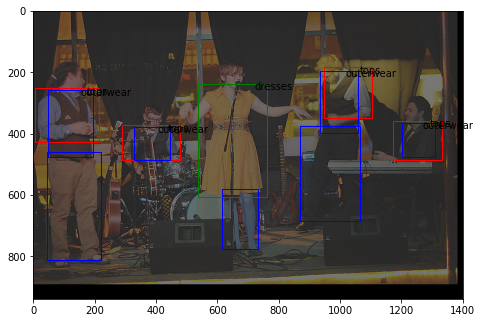

In [ ]:
visualise(img, l)

<h1>Main function<h1>

In [ ]:
for i in range(len(trainimgs)):
    im = Image.open(os.path.join(traindir, trainimgs[i]))
    labels = generateLabels(traintxts[i])
    img, l = aug_default(im, labels)
#     visualise(img, l)

    name = trainimgs[i][:-4] + "_au"
    
    if img.mode in ("RGBA", "P"): 
        img = img.convert("RGB")
        
    img.save("../til2020/newlabels/augments/{}".format(name + ".jpg"))
    
    text = []
    for c,x,y,w,h in l.tolist():
        text.append("{} {} {} {} {}\n".format(int(c), round(x, 6), round(y, 6), round(w, 6), round(h, 6)))
       
    with open("../til2020/newlabels/augments/{}".format(name + ".txt"), "w") as f:
        f.writelines(text)

/usr/local/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/site-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (106578540 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
len(os.listdir("../til2020/newlabels/augments")) / 2

9054.5

In [ ]:
checkimg = [i for i in os.listdir("../til2020/newlabels/augments") if i.endswith("jpg")]
checktxt = [i for i in os.listdir("../til2020/newlabels/augments") if i.endswith("txt")]

In [ ]:
len(checkimg)

9054

In [ ]:
len(checktxt)

9054

In [ ]:
abnormaly = [i for i in os.listdir("../til2020/newlabels/augments") if i not in checkimg and i not in checktxt]

In [ ]:
abnormaly

[]

<h1>Generate train.txt & val.txt.<h1>

In [ ]:
aug = [i for i in os.listdir("../til2020/newlabels/augments") if i.endswith("jpg")]

In [ ]:
len(aug)

9054

In [ ]:
trainimg = [i for i in os.listdir("../til2020/newlabels/trainv2") if i.endswith("jpg")]

In [ ]:
len(trainimg)

9054

In [ ]:
valimg = [i for i in os.listdir("../til2020/newlabels/valv2") if i.endswith("jpg")]
len(valimg)

1474

In [ ]:
newskirts = [i for i in os.listdir("../til2020/newlabels/newskirts") if i.endswith("jpg")]

In [ ]:
len(newskirts)

3546

In [ ]:
falsee = [i for i in os.listdir("../til2020/newlabels/falseexamples") if i.endswith("jpg")]

In [ ]:
len(falsee)

771

In [ ]:
alltrain = aug + trainimg + newskirts + falsee
len(alltrain)

22425

In [ ]:
l = []
for i in alltrain:
    text = "/home/ubuntu/darknet/build/darknet/x64/data/obj/{}\n".format(i)
    l.append(text)

with open("../til2020/newlabels/train2.txt", "w") as f:
    f.writelines(l)

In [ ]:
len(l)

22425

<h1>Check freq of classes<h1>

In [ ]:
aug = [i for i in os.listdir("../til2020/newlabels/augments") if i.endswith("txt")]
traintxt = [i for i in os.listdir("../til2020/newlabels/trainv2") if i.endswith("txt")]

In [ ]:
freq = [0,0,0,0,0]

In [ ]:
for i in aug:
    with open(os.path.join("../til2020/newlabels/augments", i), "r") as f:
        for line in f:
            x = line.strip().split(" ")
            x[0] = int(x[0])
            cat = x[0]
            if cat == 0:
                freq[0] += 1 
            elif cat == 1:
                freq[1] += 1
            elif cat == 2:
                freq[2] += 1
            elif cat == 3:
                freq[3] += 1
            elif cat == 4:
                freq[4] += 1

In [ ]:
for i in traintxt:
    with open(os.path.join("../til2020/newlabels/trainv2", i), "r") as f:
        for line in f:
            x = line.strip().split(" ")
            x[0] = int(x[0])
            cat = x[0]
            if cat == 0:
                freq[0] += 1 
            elif cat == 1:
                freq[1] += 1
            elif cat == 2:
                freq[2] += 1
            elif cat == 3:
                freq[3] += 1
            elif cat == 4:
                freq[4] += 1

In [ ]:
freqd = {k:v for k,v in enumerate(freq)}

In [ ]:
freqd

{0: 6566, 1: 7918, 2: 7426, 3: 16808, 4: 3126}

<h1>Negative Examples<h1>